In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
df_pre = pd.read_csv("../data/drama_pre_stage.csv", encoding='cp932')

In [8]:
df_pre = df_pre[["drama_key" ,"pre_part", "part_count"]]


In [9]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [10]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""
df["pre_part"] = 0.0
df["part_count"] = 0

In [11]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
        
        if tmp_drama_key in df_pre.drama_key.values:
            df["pre_part"][tmp_index] = \
                df_pre[df_pre["drama_key"] == tmp_drama_key]["pre_part"].values[0]
            df["part_count"][tmp_index] = \
                df_pre[df_pre["drama_key"] == tmp_drama_key]["part_count"].values[0]
#             float(df_pre[df_pre["drama_key"] == tmp_drama_key]["pre_part"].values[0])
#         else:
#             print(tmp_drama_key)
    
    #         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

In [12]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [13]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数69


In [14]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数69


In [15]:
df_actress_pivot

,柴咲コウ,榮倉奈々,香里奈,上戸彩,木村文乃,黒木メイサ,深津絵里,杏,多部未華子,石田ゆり子,蒼井優,真矢みき,能年玲奈,井上真央,山口智子,深田恭子,戸田恵梨香,優香,吉永小百合,松,木村佳乃,樹木希林,広瀬アリス,土屋太鳳,北川景子,柴崎コウ,小雪,米倉涼子,松雪泰子,黒木瞳,武井,上野樹里,桐谷美玲,吉田羊,石原さとみ,松下奈緒,江角マキコ,仲間由紀恵,高畑充希,天海祐希,松たか子,観月ありさ,堀北真希,芦田愛菜,佐々木希,有村架純,菅野美穂,宮崎あおい,藤原紀香,綾瀬はるか,武井咲,永作博美,吉高由里子,広瀬すず,宮_あおい,新垣結衣,常盤貴子,上戸,剛力彩芽,松嶋菜々子,波瑠,橋本環奈,竹内結子,小泉今日子,長澤まさみ,篠原涼子,菜々緒,吉瀬美智子,薬師丸ひろ子
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,7,NaN,NaN,4,NaN,23,13,NaN,NaN,NaN,26,18,NaN,28,11,20,25,12,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,19,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1,16,29,15,NaN,NaN,NaN,5,NaN,27,6,NaN,NaN,NaN,NaN,10,9,24,NaN,NaN,3,NaN,NaN,8,NaN,17,21,NaN,NaN,NaN
2011,4,NaN,NaN,3,NaN,7,11,NaN,NaN,NaN,25,20,NaN,27,28,17,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,26,NaN,30,NaN,18,NaN,NaN,21,23,NaN,5,NaN,6,19,24,14,NaN,NaN,NaN,1,NaN,NaN,2,NaN,29,NaN,NaN,9,10,NaN,NaN,NaN,8,NaN,NaN,13,16,NaN,12,NaN,NaN,NaN
2012,10,NaN,25,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,27,NaN,13,NaN,21,NaN,14,29,24,NaN,NaN,NaN,NaN,18,NaN,NaN,26,30,NaN,19,NaN,NaN,NaN,23,NaN,17,4,NaN,3,NaN,NaN,5,20,NaN,NaN,9,16,NaN,2,NaN,NaN,NaN,NaN,NaN,7,28,6,NaN,1,NaN,NaN,8,22,12,15,NaN,NaN,NaN
2013,8,NaN,NaN,4,NaN,NaN,16,NaN,NaN,NaN,NaN,22,NaN,20,NaN,13,NaN,12,27,NaN,NaN,18,NaN,NaN,14,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,19,NaN,15,7,NaN,3,NaN,NaN,2,NaN,NaN,NaN,6,24,NaN,1,26,NaN,28,NaN,NaN,9,23,NaN,30,5,NaN,NaN,25,21,17,10,NaN,NaN,29
2014,7,NaN,NaN,3,NaN,NaN,27,15,NaN,NaN,NaN,NaN,25,17,NaN,18,NaN,16,19,NaN,NaN,24,NaN,NaN,4,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,8,29,20,10,NaN,9,23,26,2,NaN,NaN,NaN,6,NaN,NaN,1,21,NaN,NaN,NaN,30,5,NaN,NaN,NaN,12,NaN,NaN,NaN,11,22,14,NaN,NaN,28
2015,6,NaN,NaN,10,NaN,NaN,28,7,NaN,NaN,NaN,NaN,17,20,NaN,18,NaN,19,25,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,9,NaN,NaN,NaN,30,29,NaN,12,NaN,NaN,3,NaN,8,11,NaN,2,NaN,21,NaN,15,NaN,NaN,1,23,NaN,26,NaN,NaN,5,NaN,NaN,NaN,14,NaN,NaN,16,24,22,13,NaN,27,NaN
2016,13,NaN,NaN,12,NaN,NaN,28,11,NaN,NaN,NaN,NaN,NaN,30,NaN,8,NaN,24,25,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,20,NaN,NaN,NaN,NaN,10,16,5,NaN,NaN,9,NaN,7,17,NaN,6,NaN,NaN,3,18,NaN,NaN,1,23,NaN,NaN,15,29,4,NaN,NaN,NaN,21,NaN,NaN,26,19,22,14,27,NaN,NaN
2017,NaN,26,NaN,12,NaN,NaN,25,14,24,20,NaN,NaN,NaN,28,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,4,13,NaN,18,NaN,NaN,NaN,NaN,9,NaN,3,NaN,NaN,7,NaN,8,NaN,NaN,15,NaN,30,6,17,NaN,NaN,2,23,NaN,21,11,NaN,1,NaN,NaN,NaN,22,NaN,NaN,29,27,16,10,NaN,NaN,NaN


In [16]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [18]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,柴咲コウ,NaN,NaN,7,4,10,8,7,6,13,NaN,16,15
1,榮倉奈々,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,NaN
2,香里奈,NaN,NaN,NaN,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
4,木村文乃,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,NaN
5,黒木メイサ,NaN,NaN,23,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,深津絵里,NaN,NaN,13,11,11,16,27,28,28,25,27,NaN
7,杏,NaN,NaN,NaN,NaN,NaN,NaN,15,7,11,14,23,NaN
8,多部未華子,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,22,14
9,石田ゆり子,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,8,10


In [19]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [20]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [21]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [22]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [23]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_new8years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2011-01-01", '%Y-%m-%d')]

In [25]:
df_new8years[ df_new8years.pre_part>0].drama_title.sort_values

<bound method Series.sort_values of 1          まだ結婚できない男
4              ドクターX
8         時効警察はじめました
10           おっさんずラブ
30             緊急取調室
34          家政夫のミタゾノ
42         家売るオンナの逆襲
63            下町ロケット
65              絶対零度
86          家政夫のミタゾノ
102             99.9
108            ドクターX
116      コード・ブルー 3rd
120             遺留捜査
134            緊急取調室
160            ドクターX
217            コウノドリ
225        花咲舞が黙ってない
258         DOCTORS3
272            MOZU2
273     ママとパパが生きる理由。
274            ドクターX
282             HERO
285              GTO
288           信長のシェフ
300        なるようになるさ。
306          刑事110キロ
307             MOZU
309      続・最後から二番目の恋
314        ファースト・クラス
319        チーム・バチスタ4
324              医龍4
337           リーガルハイ
339            ドクターX
344           都市伝説の女
350          救命病棟24時
353         ショムニ2013
355         DOCTORS2
359        警部補　矢部謙三2
360            斉藤さん2
364             ガリレオ
367             遺留捜査
380          ハンチョウ 6
415             遺留捜査
425          ハンチョウ 5
471             絶対零

In [26]:
df_new8years["main_actor1_rank"] = np.nan
df_new8years["main_actor2_rank"] = np.nan



In [27]:
for i in range(len(df_new8years)):
    prev_year = df_new8years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new8years.loc[:,df_new8years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new8years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new8years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [28]:
# df_new8years["main_actor1_rank"]

In [29]:
# df_new8years["main_actor2_rank"]

In [30]:
df_episode = df_new8years.loc[:, df_new8years.columns.str.contains("Epi")]

In [31]:
df_new8years["average_calc"] = np.nan

In [32]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new8years["average_calc"].iloc[i] = vr_sum/epi_i
            break
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new8years["average_calc"].iloc[i] = vr_sum / 15
        
    

## CM数も特徴量に

In [33]:
df_cm = pd.read_csv("../data/number_of_cm.csv", encoding='cp932')

In [34]:
df_cm["name_ns"] = df_cm.name.str.replace('\s','')

In [35]:
df_cm_pivot = pd.DataFrame(index = set(df_cm.name_ns.values),columns = range(1990,2019)  )

In [36]:
for t_name in set(df_cm.name_ns.values):
    for t_year in range(1990,2019):
        
#         tmp_q = f"name_ns == '{t_name}' & year == '{t_year}' " 
        tmp_q = "name_ns == @t_name & year == @t_year " 
# print(tmp_q)
        try :
            tmp_df = df_cm.query(tmp_q)
    #             print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
            if tmp_df["number_of_cm"].values:
#                 print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
                df_cm_pivot.loc[t_name,t_year] = int(tmp_df["number_of_cm"].values)
        except KeyError as instance:
            print (instance)
        
        

In [37]:
df_cm_pivot = df_cm_pivot.rename_axis("actor_actress").reset_index()

In [38]:
rank_arr = df_actor_namekey.actor_actress.values.tolist()

In [39]:
rank_arr.extend(df_actress_namekey.actor_actress.values)

# 特徴量エンジニアリング

### part3以降のものにフラグ

In [40]:
df_new8years["is_than_part3"] = 0

In [41]:
for tmp_idx in range(len(df_new8years)):
    if df_new8years["part_count"].iloc[tmp_idx] > 2:
        df_new8years["is_than_part3"].iloc[tmp_idx] = 1
    
    

In [42]:
df_new8years["is_than_part3"]

0      0
1      0
2      0
3      0
4      1
      ..
493    0
494    0
495    0
496    0
497    0
Name: is_than_part3, Length: 498, dtype: int64

In [43]:
df_new8years[df_new8years["is_than_part3"] == True]

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,pre_part,part_count,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,is_than_part3
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,20.9,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,1
8,EX,金23,時効警察はじめました,7.7,6.1,5.9,4.9,6.3,6.2,5.5,5.5,-,-,-,-,-,-,-,6.01,2001/5/1,2019-10-01,2019,10,1910_EX_金23,オダギリジョー,麻生久美子,,12.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.012500,1
30,EX,木21,緊急取調室,15.2,13.4,12.3,12.6,13.7,12.3,12.9,12.8,12.9,13.6,-,-,-,-,-,13.23,5-4-0,2019-04-01,2019,4,1904_EX_木21,天海祐希,田中哲司,,13.9,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,天海祐希,NaN,NaN,1,6,3,3,9,8,7,8,5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.170000,1
34,EX,金23,家政夫のミタゾノ,8.2,6.5,7.5,7.4,5.9,5.6,5.7,6.4,-,-,-,-,-,-,-,6.65,3-4-0,2019-04-01,2019,4,1904_EX_金23,松岡昌宏,伊野尾慧,,6.7,3.0,松岡昌宏,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,30,27,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.650000,1
65,CX,月21,絶対零度,10.6,9.6,10.8,11.7,10.4,10.6,10.3,10,11.3,10.8,-,-,-,-,-,10.59,4-5-0,2018-07-01,2018,7,1807_CX_月21,沢村一樹,横山裕,,13.1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.610000,1
108,EX,木21,ドクターX,20.9,19.6,19.0,19.1,20.8,20.7,20.1,20.6,21.2,25.3,-,-,-,-,-,20.87,5-4-0,2017-10-01,2017,10,1710_EX_木21,米倉涼子,永山絢斗,,21.5,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,20.730000,1
116,CX,月21,コード・ブルー 3rd,16.3,15.6,14.0,13.8,13.8,13.7,13.4,15.4,13.9,16.4,-,-,-,-,-,14.78,2002/6/1,2017-07-01,2017,7,1707_CX_月21,山下智久,新垣結衣,,16.6,3.0,山下智久,NaN,NaN,13,23,NaN,NaN,NaN,NaN,NaN,NaN,28,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,新垣結衣,NaN,NaN,9,10,7,9,5,5,4,1,2,2,13.0,9.0,14.630000,1
120,EX,木20,遺留捜査,13.1,8.8,10.9,10.8,10.1,10.8,10.3,11.2,10.6,-,-,-,-,-,-,10.97,3-5-0,2017-07-01,2017,7,1707_EX_木20,上川隆也,栗山千明,,11.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.733333,1
160,EX,木21,ドクターX,20.4,19.7,24.3,21.3,20.4,21.5,22.2,20.7,22.6,20.5,22.8,-,-,-,-,21.45,5-5-0,2016-10-01,2016,10,1610_EX_木21,米倉涼子,生瀬勝久,,22.9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,21.490909,1
258,EX,木21,DOCT

### 前の枠の数字

In [44]:
df_new8years["pre_slot_vr_average"] = np.nan

In [45]:
val_for_nan = sum(df_new8years.average)/len(df_new8years)

In [46]:
for tmp_idx in range(len(df_new8years)):
    if df_new8years["start_at_month"].iloc[tmp_idx] == 1:
        pre_slot_month = str(10) 
        pre_slot_year = df_new8years["start_at_year"].iloc[tmp_idx] - 1
    else:
        pre_slot_month = "0"+ str(int(df_new8years["start_at_month"].iloc[tmp_idx]) - 3) 
        pre_slot_year = df_new8years["start_at_year"].iloc[tmp_idx]
        
    time_table = df_new8years["time_table"].iloc[tmp_idx]
    TV_station = df_new8years["TV_station"].iloc[tmp_idx]
#     print(f"{pre_slot_year%2000}{pre_slot_month}_{time_table}_{TV_station} ")
    pre_key =  str(pre_slot_year%2000) + pre_slot_month+"_"+TV_station+"_"+time_table
    try:
        if pre_key in df["drama_key"].values:
            tmp_pre_slot_vr_average = float(df[df["drama_key"]==pre_key].average) 
        else:
            tmp_pre_slot_vr_average = val_for_nan
#         print(pre_key)
    except:
        print(pre_key)
        tmp_pre_slot_vr_average = float(df[df["drama_key"]==pre_key].average.values[0])
    
    print(tmp_pre_slot_vr_average)
    
    df_new8years["pre_slot_vr_average"].iloc[tmp_idx] = tmp_pre_slot_vr_average
#         float(df[df["drama_key"]==pre_key].average)

12.56
9.345783132530123
8.68
10.31
11.09
7.17
3.28
9.95
3.55
10.94
2.34
11.96
11.49
12.15
6.37
9.72
8.71
13.23
6.71
2.31
9.22
6.65
8.69
3.94
10.48
7.01
10.75
6.25
8.5
11.46
10.65
6.83
2.98
10.31
4.11
9.14
3.13
9.77
11.47
10.81
6.58
6.92
8.75
15.74
6.71
3.33
10.11
5.25
8.83
3.59
13.61
9.87
10.59
5.8
14.15
9.49
10.41
11.24
3.16
7.14
4.51
8.87
3.91
9.77
6.62
8.88
7.79
8.3
9.77
13.02
6.23
3.03
8.46
6.73
8.24
3.99
14.29
7.45
6.14
6.93
7.74
6.16
15.24
6.26
3.09
11.14
5.19
9.82
3.47
17.63
6.95
6.74
5.75
7.73
12.65
20.87
6.53
3.48
11.87
4.83
8.77
9.345783132530123
16.0
6.19
14.78
6.07
10.17
11.47
11.45
4.5
3.45
7.33
4.0
8.7
9.73
8.58
8.77
10.58
11.25
9.17
9.345783132530123
14.09
6.44
3.33
8.79
5.45
9.55
13.6
5.35
7.68
6.65
11.3
8.9
11.39
9.74
6.53
3.42
8.32
6.46
9.345783132530123
14.55
4.99
9.3
8.23
8.13
14.58
12.37
21.45
7.05
3.53
10.18
7.66
8.31
7.18
10.66
7.17
8.92
9.345783132530123
7.92
11.59
9.86
7.1
2.93
5.62
5.64
6.66
6.13
10.58
8.27
8.54
8.18
8.02
12.88
10.77
5.61
3.47
9.03
7.7
7.91
4.

In [47]:
df_new8years = df_new8years.fillna({'part_count': 0})

### 俳優ランクを人気ポイントに

In [48]:
df_new8years["main_actor1_pt"] = df_new8years["main_actor1_rank"].apply(lambda x : (41 - x)/40 )

In [49]:
df_new8years["main_actor2_pt"] = df_new8years["main_actor2_rank"].apply(lambda x : (41 - x)/40 )

In [50]:
df_new8years["main_actor1_pt"] = df_new8years["main_actor1_pt"].fillna(0)
df_new8years["main_actor2_pt"] = df_new8years["main_actor2_pt"].fillna(0)

In [51]:
df_new8years["has_original_work"] = df_new8years["original_work"].apply(lambda x : 0 if x =="" else 1 ) 

### 年を特徴量エンジニアリング

In [52]:
df_new8years["year_feature"] =  df_new8years["start_at_year"] - 2010

### (TODO) CM数も特徴量に加工する

### one hotエンコーディング

In [53]:
# df_new8years = pd.get_dummies(df_new8years, columns=["TV_station", "start_at_month", "start_at_year","time_table"] )
df_new8years = pd.get_dummies(df_new8years, columns=["TV_station", "start_at_month","time_table"] )

## wikiの俳優情報を特徴量として

In [54]:
f = open("../data/actor_wiki0220.json", 'r')
print(f)
actor_wiki_json = json.load(f)
df_actor_wiki = pd.read_excel("../data/wiki_raw.xlsx" )



<_io.TextIOWrapper name='../data/actor_wiki0220.json' mode='r' encoding='UTF-8'>


In [55]:
df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"]["office"] = "ジャニーズ事務所"

In [56]:
target_idx = df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"].index.values

In [57]:
df_actor_wiki["office"].iloc[target_idx] = "ジャニーズ事務所"

In [58]:
df_actor_wiki.iloc[target_idx]["office"]

18    ジャニーズ事務所
Name: office, dtype: object

In [59]:
# Jかどうか
df_actor_wiki["isj"] = df_actor_wiki["office"] == "ジャニーズ事務所"

In [60]:
# df_new8years["actor1_office"] = np.nan
# df_new8years["actor2_office"] = np.nan
# df_new8years["actor1_birthday"] = np.nan
# df_new8years["actor2_birthday"] = np.nan
df_new8years["actor1_isj"] = 0
df_new8years["actor2_isj"] = 0

In [61]:
for idx in range(len(df_new8years)):
    actor1 = df_new8years["main_actor1"].iloc[idx]
    actor2 = df_new8years["main_actor2"].iloc[idx]
    
    if actor1 in  df_actor_wiki["actor_name"].values :
        df_new8years["actor1_isj"].iloc[idx] = \
            int(df_actor_wiki[df_actor_wiki["actor_name"] == actor1].isj.values[0])
    
    if actor2 in  df_actor_wiki["actor_name"].values :
        df_new8years["actor2_isj"].iloc[idx] = \
            int(df_actor_wiki[df_actor_wiki["actor_name"] == actor2].isj.values[0])
        

In [62]:
# df_new8years[df_new8years["actor1_isj"]==True]

In [63]:
# for idx in range(len(df_new8years)):
#     actor1 = df_new8years["main_actor1"].iloc[idx]
#     actor2 = df_new8years["main_actor2"].iloc[idx]
# #     print(actor1)
    
#     if actor_wiki_json[actor1]:
    
#         df_new8years["actor1_office"].iloc[idx] = actor_wiki_json[actor1].get("office")
#         df_new8years["actor1_birthday"].iloc[idx] = actor_wiki_json[actor1].get("birthday")
    
#     if actor_wiki_json[actor2]:
#         df_new8years["actor2_office"].iloc[idx] = actor_wiki_json[actor2].get("office")
#         df_new8years["actor2_birthday"].iloc[idx] = actor_wiki_json[actor2].get("birthday")

### dummy化

In [64]:
X = df_new8years[["main_actor1_pt" , "main_actor2_pt", "actor1_isj","actor2_isj", \
                  "pre_part","pre_slot_vr_average","has_original_work",\
                  "is_than_part3","year_feature"]]

In [65]:
# X_dummys = df_new8years.loc[:,df_new8years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_|time_table'))]
X_dummys = df_new8years.loc[:,df_new8years.columns.str.contains(('start_at_year_|start_at_month_|time_table'))]

In [66]:
X_dummys

,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,time_table_土21,time_table_土22,time_table_土23,time_table_日21,time_table_日22,time_table_日23,time_table_月20,time_table_月21,time_table_木20,time_table_木21,time_table_木22,time_table_木23,time_table_水21,time_table_水22,time_table_火21,time_table_火22,time_table_金20,time_table_金22,time_table_金23
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
494,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
495,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
496,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
X = pd.concat([X,X_dummys], axis=1)


#### モデル作成

In [68]:
y = df_new8years["average"]

In [69]:
lm = LinearRegression()

In [70]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12345 )

In [71]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [72]:
y_pred = lm.predict(X_test)

In [73]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [74]:
print(lm_rmse)

2.316069860399685


In [75]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    c = df_new8years.iloc[y_test.index[i]].drama_title
    print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

きょうは会社休みます。	 視聴率：実際 16.01   	 予測 11.766969632604804 
嫌われる勇気	 視聴率：実際 6.53   	 予測 6.928000005241472 
ラヴソング	 視聴率：実際 8.54   	 予測 9.91870004831976 
お義父さんと呼ばせて	 視聴率：実際 6.94   	 予測 7.977763865538465 
SUITS	 視聴率：実際 10.81   	 予測 9.49201096965139 
イノセンス	 視聴率：実際 9.14   	 予測 8.297386035064013 
VISION	 視聴率：実際 3.02   	 予測 4.057033896010076 
恋愛ニート	 視聴率：実際 9.14   	 予測 10.919100265147161 
失恋保険 告らせ屋	 視聴率：実際 3.82   	 予測 5.099795498791654 
あなたには帰る家がある	 視聴率：実際 8.46   	 予測 9.244119224675527 
謎解きはディナーのあとで	 視聴率：実際 15.93   	 予測 12.293833181373385 
チーム・バチスタ3	 視聴率：実際 12.85   	 予測 12.979058373182824 
健康で文化的な最低限度の生活	 視聴率：実際 5.8   	 予測 7.258769151471042 
青春探偵ハルヤ	 視聴率：実際 4.32   	 予測 4.302580145679352 
パーフェクトワールド	 視聴率：実際 6.37   	 予測 6.983365512159779 
HEAT	 視聴率：実際 4.12   	 予測 6.914574579310567 
浪花少年探偵団	 視聴率：実際 6.13   	 予測 8.531343718538455 
心がポキッとね	 視聴率：実際 6.71   	 予測 9.495394615334115 
おっさんずラブ	 視聴率：実際 4.56   	 予測 4.084923826369893 
A LIFE	 視聴率：実際 14.55   	 予測 12.492258088092377 
わたし、定時で帰ります。	 視聴率：実際 9.72   	 予測 7.

In [76]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    c = df_new8years.iloc[y_test.index[i]].drama_title
    d = df_new8years.iloc[y_test.index[i]].main_actor1_pt
    e = df_new8years.iloc[y_test.index[i]].main_actor2_pt
    f = df_new8years.iloc[y_test.index[i]].pre_part
    g = df_new8years.iloc[y_test.index[i]].pre_slot_vr_average
    if abs (a-b) > 2:
        print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ,{d} ,{e},{f}, {g}')

きょうは会社休みます。	 視聴率：実際 16.01   	 予測 11.766969632604804 ,0.875 ,0.0,0.0, 11.32
謎解きはディナーのあとで	 視聴率：実際 15.93   	 予測 12.293833181373385 ,1.0 ,0.0,0.0, 13.13
HEAT	 視聴率：実際 4.12   	 予測 6.914574579310567 ,0.0 ,0.0,0.0, 4.78
浪花少年探偵団	 視聴率：実際 6.13   	 予測 8.531343718538455 ,0.0 ,0.0,0.0, 11.15
心がポキッとね	 視聴率：実際 6.71   	 予測 9.495394615334115 ,0.0 ,0.0,0.0, 7.68
A LIFE	 視聴率：実際 14.55   	 予測 12.492258088092377 ,0.925 ,0.825,0.0, 10.66
わたし、定時で帰ります。	 視聴率：実際 9.72   	 予測 7.152820860306173 ,0.0 ,0.0,0.0, 8.5
グッド・ドクター	 視聴率：実際 11.24   	 予測 6.46219117002429 ,0.0 ,0.0,0.0, 6.23
ぴんとこな	 視聴率：実際 7.5   	 予測 9.923227729798288 ,0.0 ,0.0,0.0, 9.86
昼顔	 視聴率：実際 13.9   	 予測 10.044534437051823 ,0.925 ,0.0,0.0, 12.86
お天気お姉さん	 視聴率：実際 9.84   	 予測 7.42927757177074 ,0.0 ,0.0,0.0, 10.84
PRICELESS	 視聴率：実際 17.71   	 予測 13.121939589504551 ,0.925 ,0.0,0.0, 12.4
リーガルV	 視聴率：実際 15.74   	 予測 9.643142126391414 ,0.55 ,0.0,0.0, 10.41
夫のカノジョ	 視聴率：実際 3.87   	 予測 9.703488387364775 ,0.0 ,0.0,0.0, 7.5
ドクターX	 視聴率：実際 22.98   	 予測 16.910462378974067 ,0.

In [77]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	1.141881606969754 
1  回帰係数 main_actor2_pt	1.3436583753534708 
2  回帰係数 actor1_isj	0.38078903897169647 
3  回帰係数 actor2_isj	-0.27233404251132015 
4  回帰係数 pre_part	0.21547952612206905 
5  回帰係数 pre_slot_vr_average	0.23374276679832692 
6  回帰係数 has_original_work	0.06581657791349013 
7  回帰係数 is_than_part3	0.939623006998422 
8  回帰係数 year_feature	-0.26055120365527323 
9  回帰係数 start_at_month_1	0.018076951752948107 
10  回帰係数 start_at_month_4	0.07726577166778081 
11  回帰係数 start_at_month_7	-0.2678456535456522 
12  回帰係数 start_at_month_10	0.17250293012526152 
13  回帰係数 time_table_土21	1.2363023556369765 
14  回帰係数 time_table_土22	1.286429848845832 
15  回帰係数 time_table_土23	-2.425385886187737 
16  回帰係数 time_table_日21	1.986902546237378 
17  回帰係数 time_table_日22	1.3853988951402407 
18  回帰係数 time_table_日23	-2.504416035569245 
19  回帰係数 time_table_月20	-0.6256480848536481 
20  回帰係数 time_table_月21	1.8612077964383968 
21  回帰係数 time_table_木20	-0.7764763189922949 
22  回帰係数 time_table_木21	1.21986

In [78]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 7.274


In [79]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.5982739223789096


In [80]:
# lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print (f"rmse: {lm_rmse}")

# モデル２決定木

In [81]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 16)
# clf = DecisionTreeRegressor(max_leaf_nodes= 12)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=16, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [82]:
y_pred_tree = clf.predict(X_test)

In [83]:
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (rf_rmse)

2.9566284449271896


In [84]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.06782910484881959 
1  FI main_actor2_pt     	0.08317460843289846 
2  FI actor1_isj     	0.028591457109741557 
3  FI actor2_isj     	0.0 
4  FI pre_part     	0.1612778095779022 
5  FI pre_slot_vr_average     	0.605319788784949 
6  FI has_original_work     	0.0 
7  FI is_than_part3     	0.0 
8  FI year_feature     	0.029565744464862227 
9  FI start_at_month_1     	0.0 
10  FI start_at_month_4     	0.0 
11  FI start_at_month_7     	0.0 
12  FI start_at_month_10     	0.0 
13  FI time_table_土21     	0.0 
14  FI time_table_土22     	0.0 
15  FI time_table_土23     	0.0 
16  FI time_table_日21     	0.0 
17  FI time_table_日22     	0.0 
18  FI time_table_日23     	0.0 
19  FI time_table_月20     	0.0 
20  FI time_table_月21     	0.0 
21  FI time_table_木20     	0.0 
22  FI time_table_木21     	0.02424148678082705 
23  FI time_table_木22     	0.0 
24  FI time_table_木23     	0.0 
25  FI time_table_水21     	0.0 
26  FI time_table_水22     	0.0 
27  FI time_table_火21     	0.0 
28 

In [85]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 16.01   	 予測 11.766969632604804 
視聴率：実際 6.53   	 予測 6.928000005241472 
視聴率：実際 8.54   	 予測 9.91870004831976 
視聴率：実際 6.94   	 予測 7.977763865538465 
視聴率：実際 10.81   	 予測 9.49201096965139 
視聴率：実際 9.14   	 予測 8.297386035064013 
視聴率：実際 3.02   	 予測 4.057033896010076 
視聴率：実際 9.14   	 予測 10.919100265147161 
視聴率：実際 3.82   	 予測 5.099795498791654 
視聴率：実際 8.46   	 予測 9.244119224675527 
視聴率：実際 15.93   	 予測 12.293833181373385 
視聴率：実際 12.85   	 予測 12.979058373182824 
視聴率：実際 5.8   	 予測 7.258769151471042 
視聴率：実際 4.32   	 予測 4.302580145679352 
視聴率：実際 6.37   	 予測 6.983365512159779 
視聴率：実際 4.12   	 予測 6.914574579310567 
視聴率：実際 6.13   	 予測 8.531343718538455 
視聴率：実際 6.71   	 予測 9.495394615334115 
視聴率：実際 4.56   	 予測 4.084923826369893 
視聴率：実際 14.55   	 予測 12.492258088092377 
視聴率：実際 9.72   	 予測 7.152820860306173 
視聴率：実際 11.24   	 予測 6.46219117002429 
視聴率：実際 12.86   	 予測 13.982914264431553 
視聴率：実際 7.5   	 予測 9.923227729798288 
視聴率：実際 3.09   	 予測 2.8758524169743094 
視聴率：実際 13.9   	 予測 10.044534437051823 
視聴

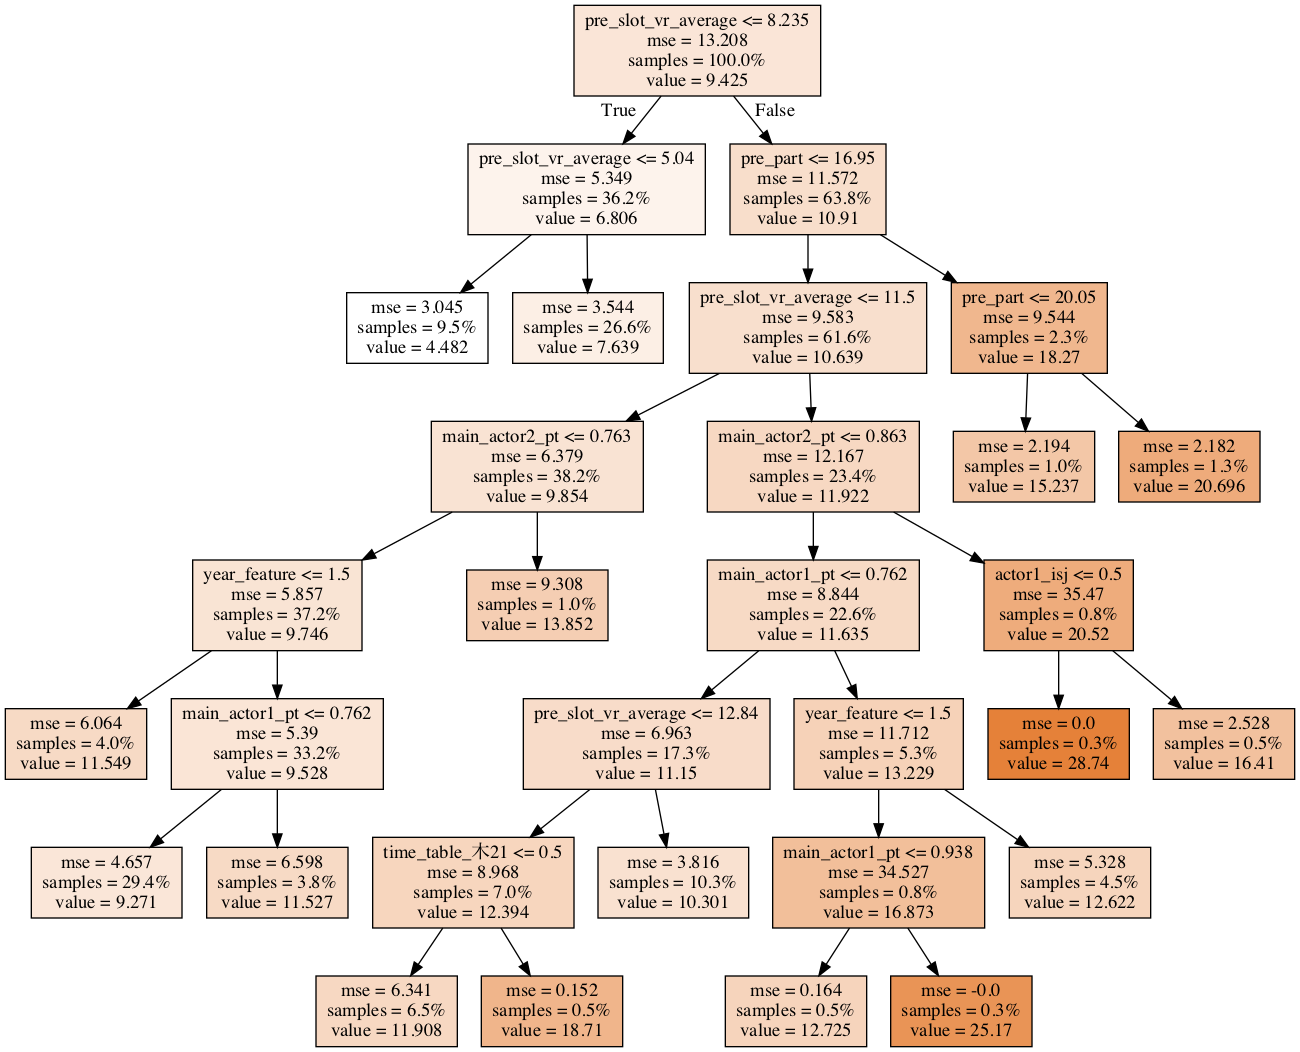

In [86]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### モデル３　線形回帰 目的変数を初回に

In [87]:
y1 = df_new8years["Episode1"]

In [88]:
lm1 = LinearRegression()

In [89]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y1,test_size=0.2,random_state=12345 )

In [90]:
model1 = lm1.fit(X_train1,y_train1)
#predictions=model.predict(x_test)

In [91]:
y_pred1 = lm1.predict(X_test1)

In [92]:
lm1_rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))

In [93]:
print(lm1_rmse)

2.091617007191649


In [94]:
for i in range(len(y_pred1)):
    a = y_test1.values[i]
    b = y_pred1[i]
    c = df_new8years.iloc[y_test1.index[i]].drama_title
    print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

きょうは会社休みます。	 視聴率：実際 14.3   	 予測 13.227472308528531 
嫌われる勇気	 視聴率：実際 8.1   	 予測 7.623543819696788 
ラヴソング	 視聴率：実際 10.6   	 予測 11.368061620202864 
お義父さんと呼ばせて	 視聴率：実際 9.6   	 予測 8.946048288380748 
SUITS	 視聴率：実際 14.2   	 予測 10.896072342734218 
イノセンス	 視聴率：実際 8.3   	 予測 10.039087822753725 
VISION	 視聴率：実際 4.1   	 予測 5.132279669177624 
恋愛ニート	 視聴率：実際 11.9   	 予測 12.567887806875044 
失恋保険 告らせ屋	 視聴率：実際 7.3   	 予測 5.973291808527742 
あなたには帰る家がある	 視聴率：実際 9.3   	 予測 10.698332876401674 
謎解きはディナーのあとで	 視聴率：実際 18.1   	 予測 14.873033508309902 
チーム・バチスタ3	 視聴率：実際 14.2   	 予測 15.012746070011222 
健康で文化的な最低限度の生活	 視聴率：実際 7.6   	 予測 9.146979214971129 
青春探偵ハルヤ	 視聴率：実際 5.1   	 予測 5.361345219983027 
パーフェクトワールド	 視聴率：実際 6.9   	 予測 8.385979045795949 
HEAT	 視聴率：実際 6.6   	 予測 8.05586411464783 
浪花少年探偵団	 視聴率：実際 7.8   	 予測 10.169956703199746 
心がポキッとね	 視聴率：実際 10.4   	 予測 10.44721312814102 
おっさんずラブ	 視聴率：実際 5.8   	 予測 4.634935496474732 
A LIFE	 視聴率：実際 14.2   	 予測 13.460187710924167 
わたし、定時で帰ります。	 視聴率：実際 9.5   	 予測 7.90588212893

In [95]:
for i in range(len(y_pred1)):
    a = y_test1.values[i]
    b = y_pred1[i]
    c = df_new8years.iloc[y_test1.index[i]].drama_title
    if abs (a-b) > 3:
        print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

SUITS	 視聴率：実際 14.2   	 予測 10.896072342734218 
謎解きはディナーのあとで	 視聴率：実際 18.1   	 予測 14.873033508309902 
グッド・ドクター	 視聴率：実際 11.5   	 予測 7.527421961848001 
お天気お姉さん	 視聴率：実際 11.9   	 予測 8.21152718303545 
リーガルV	 視聴率：実際 15.0   	 予測 10.449551494676143 
夫のカノジョ	 視聴率：実際 4.7   	 予測 11.28949747634621 
ドクターX	 視聴率：実際 22.8   	 予測 18.600118818705635 
dinner	 視聴率：実際 8.8   	 予測 12.315279812462766 
JIN -仁-	 視聴率：実際 23.7   	 予測 19.639768573006688 
DOCTORS3	 視聴率：実際 14.6   	 予測 19.10215677575149 
緊急取調室	 視聴率：実際 17.9   	 予測 13.726660627621303 
東京バンドワゴン	 視聴率：実際 8.8   	 予測 14.13890931048305 
明日、ママがいない	 視聴率：実際 14.0   	 予測 10.86437220079738 
ハングリー！	 視聴率：実際 14.2   	 予測 10.846723673497591 
ドクターX	 視聴率：実際 20.4   	 予測 17.112572955809405 
下町ロケット	 視聴率：実際 16.1   	 予測 12.186470298072006 
アリスの棘	 視聴率：実際 14.2   	 予測 9.83883116639638 


In [96]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model1.coef_[i]} """)

0  回帰係数 main_actor1_pt	1.0003659776011606 
1  回帰係数 main_actor2_pt	1.6416562545897442 
2  回帰係数 actor1_isj	0.5551536538829234 
3  回帰係数 actor2_isj	-0.5817092579749148 
4  回帰係数 pre_part	0.22535399273087223 
5  回帰係数 pre_slot_vr_average	0.2580889568185651 
6  回帰係数 has_original_work	0.3363637192577496 
7  回帰係数 is_than_part3	0.9224349880725083 
8  回帰係数 year_feature	-0.360964482886996 
9  回帰係数 start_at_month_1	0.013172876397465514 
10  回帰係数 start_at_month_4	-0.09463950473561242 
11  回帰係数 start_at_month_7	-0.0920608119480176 
12  回帰係数 start_at_month_10	0.17352744028656125 
13  回帰係数 time_table_土21	2.0864163582406414 
14  回帰係数 time_table_土22	2.125631280705337 
15  回帰係数 time_table_土23	-2.6652942506337527 
16  回帰係数 time_table_日21	1.5176408189232768 
17  回帰係数 time_table_日22	1.4150414658269947 
18  回帰係数 time_table_日23	-3.4547448460833694 
19  回帰係数 time_table_月20	-1.100147629788951 
20  回帰係数 time_table_月21	2.252405728626229 
21  回帰係数 time_table_木20	-0.20231531532080246 
22  回帰係数 time_table_木21	1.056794

In [97]:
print('モデル関数の切片 w2: %.3f' %model1.intercept_)

モデル関数の切片 w2: 8.870


In [98]:
print('決定係数 R^2： ', model1.score(X, y1))

決定係数 R^2：  0.6745033473572373


In [99]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

np.random.seed(9876789)

In [100]:
# Fit and summary:

# Fit and summary:

model_sm = sm.OLS(y, sm.add_constant(X))
res = model_sm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                average   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     23.56
Date:                Fri, 28 Feb 2020   Prob (F-statistic):           7.62e-75
Time:                        16:30:11   Log-Likelihood:                -1136.7
No. Observations:                 498   AIC:                             2335.
Df Residuals:                     467   BIC:                             2466.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.5338    

In [101]:
len(res.predict())

498

In [102]:
res.predict()[y_test.index]

array([12.11951991,  7.04598494,  9.87221767,  8.0673985 ,  9.56259987,
        8.38190582,  3.89678414, 11.11056297,  4.98920598,  9.20018916,
       12.4606034 , 12.9512819 ,  7.19338423,  4.19520696,  7.03834959,
        6.98743391,  8.19877355,  9.46507213,  4.42830343, 12.75163047,
        7.35462398,  6.55603927, 14.26112549,  9.69690544,  2.86693397,
       10.38968913,  9.4223753 ,  7.52945929,  3.50292359,  8.50888459,
        5.22609461,  6.95700394,  8.78174843,  9.43391022,  6.62550348,
       13.27371452,  4.30434253,  7.49423256, 11.70618589, 10.05047348,
        9.80237192, 13.77141862,  7.67849701, 17.58089157,  7.78550575,
       10.56779902, 12.13410888,  7.66404814, 14.43802148,  8.83143763,
       11.38550864, 18.08863601, 10.14289426,  5.22193481,  5.73516478,
        8.64828908,  3.47531059,  6.47416208, 17.4424403 ,  3.31788747,
       13.74585364, 10.87740754,  6.1399964 ,  8.79623593,  3.90882925,
       12.14681745,  7.00339852,  9.55148843,  5.18575299,  4.59

In [103]:
def rmse_accuracy_percentage(actual,predicted): 
    a = actual
    b = predicted
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))

In [104]:
rmse_accuracy_percentage( y_test, res.predict()[y_test.index])

RMSE is: 2.21


In [105]:
model_sm1 = sm.OLS(y1, sm.add_constant(X))
res1 = model_sm1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:               Episode1   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     32.71
Date:                Fri, 28 Feb 2020   Prob (F-statistic):           1.94e-95
Time:                        16:30:11   Log-Likelihood:                -1097.1
No. Observations:                 498   AIC:                             2256.
Df Residuals:                     467   BIC:                             2387.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.8657    

In [106]:
rmse_accuracy_percentage( y_test, res1.predict()[y_test.index])

RMSE is: 2.63
